## Create null timeseries for a control DyNeuSR

Based on the paper [1]. Essentially, we create a surrogate data matrix that matches the empirical fMRI in covariance and spectral structure.

[1] Laumann, T. O., Snyder, A. Z., Mitra, A., Gordon, E. M., Gratton, C., Adeyemo, B., … Petersen, S. E. (2017). On the Stability of BOLD fMRI Correlations. Cerebral Cortex, 27(10), 4719–4732. https://doi.org/10.1093/cercor/bhw265

#### Load data

In [1]:
from utils import *
%pylab nbagg

majorRSNs = ['Cingulo_opercular','Frontoparietal_1','Somatomotor','Visual_2','DMN']
 
df_behavior = pd.read_table('data/base/behavior/trackingdata_goodscans.txt')

sessions = load_scrubbed(n_sessions=-1, merge=False)

roi2rsn = np.array(sessions[0].atlas['data']['network'])
roi2rsn_clean = roi2rsn[np.isin(roi2rsn,majorRSNs)]

/Users/rafi/miniconda/envs/dyno/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
INFO:load_data:load_scrubbed(**{'n_sessions': -1, 'merge': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 1, path: data/base/combined_data_scrubbed/sub014.txt


Populating the interactive namespace from numpy and matplotlib


INFO:root:  [+] session: 2, path: data/base/combined_data_scrubbed/sub015.txt
INFO:root:  [+] session: 3, path: data/base/combined_data_scrubbed/sub016.txt
INFO:root:  [+] session: 4, path: data/base/combined_data_scrubbed/sub017.txt
INFO:root:  [+] session: 5, path: data/base/combined_data_scrubbed/sub018.txt
INFO:root:  [+] session: 6, path: data/base/combined_data_scrubbed/sub019.txt
INFO:root:  [+] session: 7, path: data/base/combined_data_scrubbed/sub020.txt
INFO:root:  [+] session: 8, path: data/base/combined_data_scrubbed/sub021.txt
INFO:root:  [+] session: 9, path: data/base/combined_data_scrubbed/sub022.txt
INFO:root:  [+] session: 10, path: data/base/combined_data_scrubbed/sub023.txt
INFO:root:  [+] session: 11, path: data/base/combined_data_scrubbed/sub024.txt
INFO:root:  [+] session: 12, path: data/base/combined_data_scrubbed/sub025.txt
INFO:root:  [+] session: 13, path: data/base/combined_data_scrubbed/sub026.txt
INFO:root:  [+] session: 14, path: data/base/combined_data_s

In [2]:
def clean_data(datamat,subject_index):
    # Datamat must be TRs x ROIs
    newdata = np.array(datamat)
    # Get subcode
    subcode = df_behavior.loc[subject_index,'subcode']
    # Load temporal mask
    tmask = np.loadtxt('data/base/rsfmri/tmasks/' + subcode + '.txt').astype(bool)
    # Clean data
    newdata = newdata[tmask,:]
    newdata = newdata[:,np.isin(roi2rsn,majorRSNs)]

    return newdata  

#### Match covariance and spectral structure

In [3]:
sessions_clean = [clean_data(session.X, ind) for ind,session in enumerate(sessions)]

# Create covariance matrix
C = [np.cov(session.T) for session in sessions_clean]

Y = []
for ind,c in enumerate(C):
    print('Processing %d out of %d...' % (ind+1, len(C)))
    n,d = sessions_clean[ind].shape
    # Diagonalize the covariance matrix - get eigenvectors and eigenvalues
    lamb,W =  np.linalg.eigh(c)
    lamb = lamb[::-1] # in descending order
    lambmat = np.diag(lamb)
    W = W[:,::-1]

    # Create matrix of random normal deviates - Z is d x n, where d = ROIs, n = TRs
    Z = np.random.normal(size=(d,n))

    # Get mean power spectral density across ROIs
    p_all = []
    for roi in sessions_clean[ind].T:
        ps = np.abs(np.fft.fft(roi))
        p_all.append(ps)

    pmean = np.mean(p_all,axis=0)

    # FFT the Z matrix
    Zf = np.array([np.fft.fft(z) for z in Z])
    # Multiply each column by corresponding value in PSD
    Zp = np.array([np.sqrt(pmean[j])*z for j,z in enumerate(Zf.T)]).T
    # Inverse FFT to get S
    S = np.array([np.fft.ifft(z) for z in Zp])
    # Zero mean and unit variance for each row
    X = scipy.stats.zscore(S,axis=1)

    # Construct Y - matrix with matching covariance and spectrum
    lambmat2 = np.nan_to_num(np.power(lambmat,0.5))
    
    y = np.dot(np.dot(W,lambmat2),X)
    
    Y.append(y.real)

Processing 1 out of 84...
Processing 2 out of 84...
Processing 3 out of 84...
Processing 4 out of 84...
Processing 5 out of 84...
Processing 6 out of 84...
Processing 7 out of 84...
Processing 8 out of 84...
Processing 9 out of 84...
Processing 10 out of 84...


/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in power


Processing 11 out of 84...
Processing 12 out of 84...
Processing 13 out of 84...
Processing 14 out of 84...
Processing 15 out of 84...
Processing 16 out of 84...
Processing 17 out of 84...
Processing 18 out of 84...
Processing 19 out of 84...
Processing 20 out of 84...
Processing 21 out of 84...
Processing 22 out of 84...
Processing 23 out of 84...
Processing 24 out of 84...
Processing 25 out of 84...
Processing 26 out of 84...
Processing 27 out of 84...
Processing 28 out of 84...
Processing 29 out of 84...
Processing 30 out of 84...
Processing 31 out of 84...
Processing 32 out of 84...
Processing 33 out of 84...
Processing 34 out of 84...
Processing 35 out of 84...
Processing 36 out of 84...
Processing 37 out of 84...
Processing 38 out of 84...
Processing 39 out of 84...
Processing 40 out of 84...
Processing 41 out of 84...
Processing 42 out of 84...
Processing 43 out of 84...
Processing 44 out of 84...
Processing 45 out of 84...
Processing 46 out of 84...
Processing 47 out of 84...
P

<IPython.core.display.Javascript object>


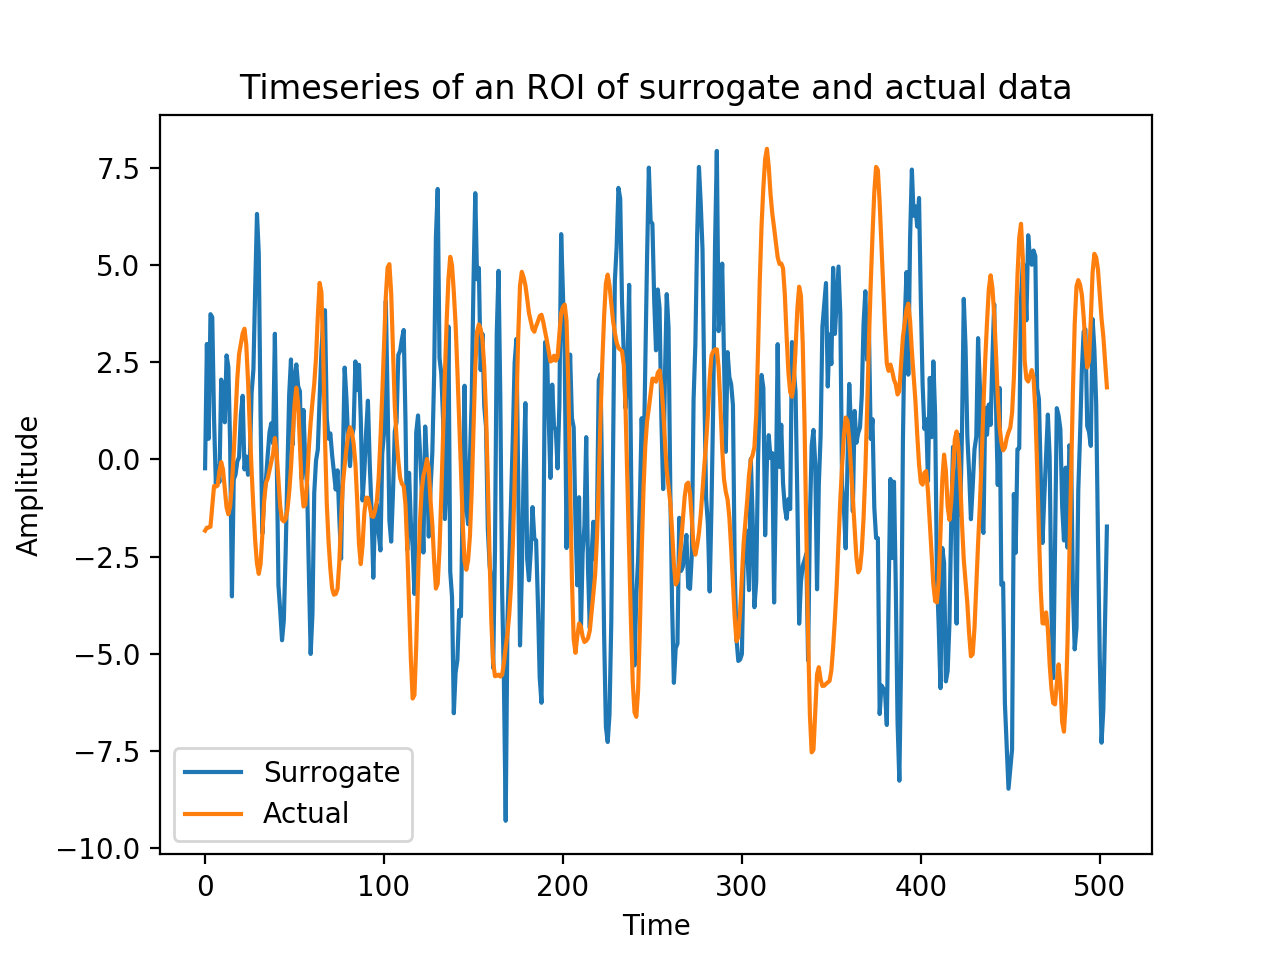

<IPython.core.display.Javascript object>


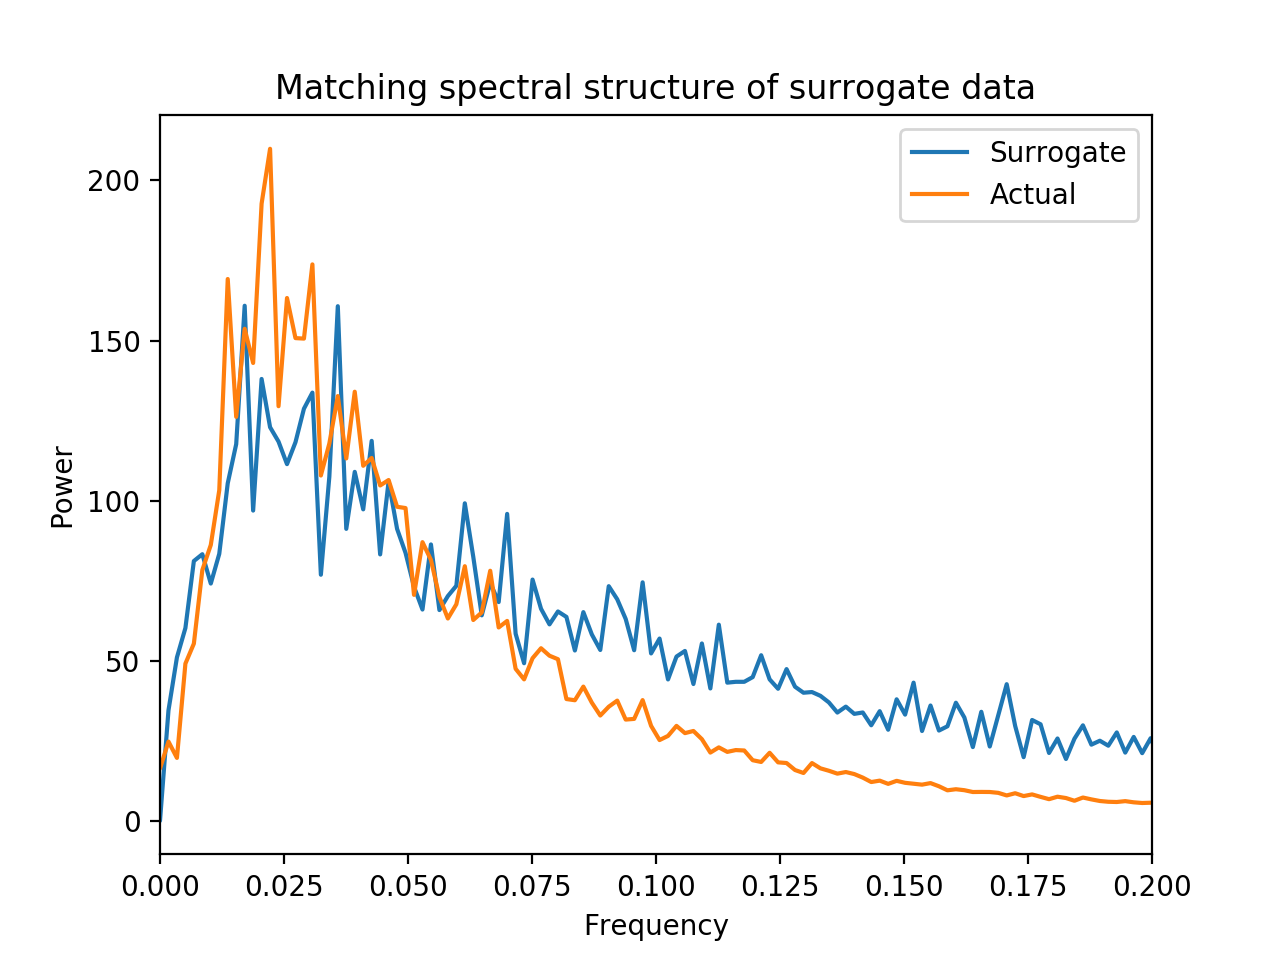

<IPython.core.display.Javascript object>


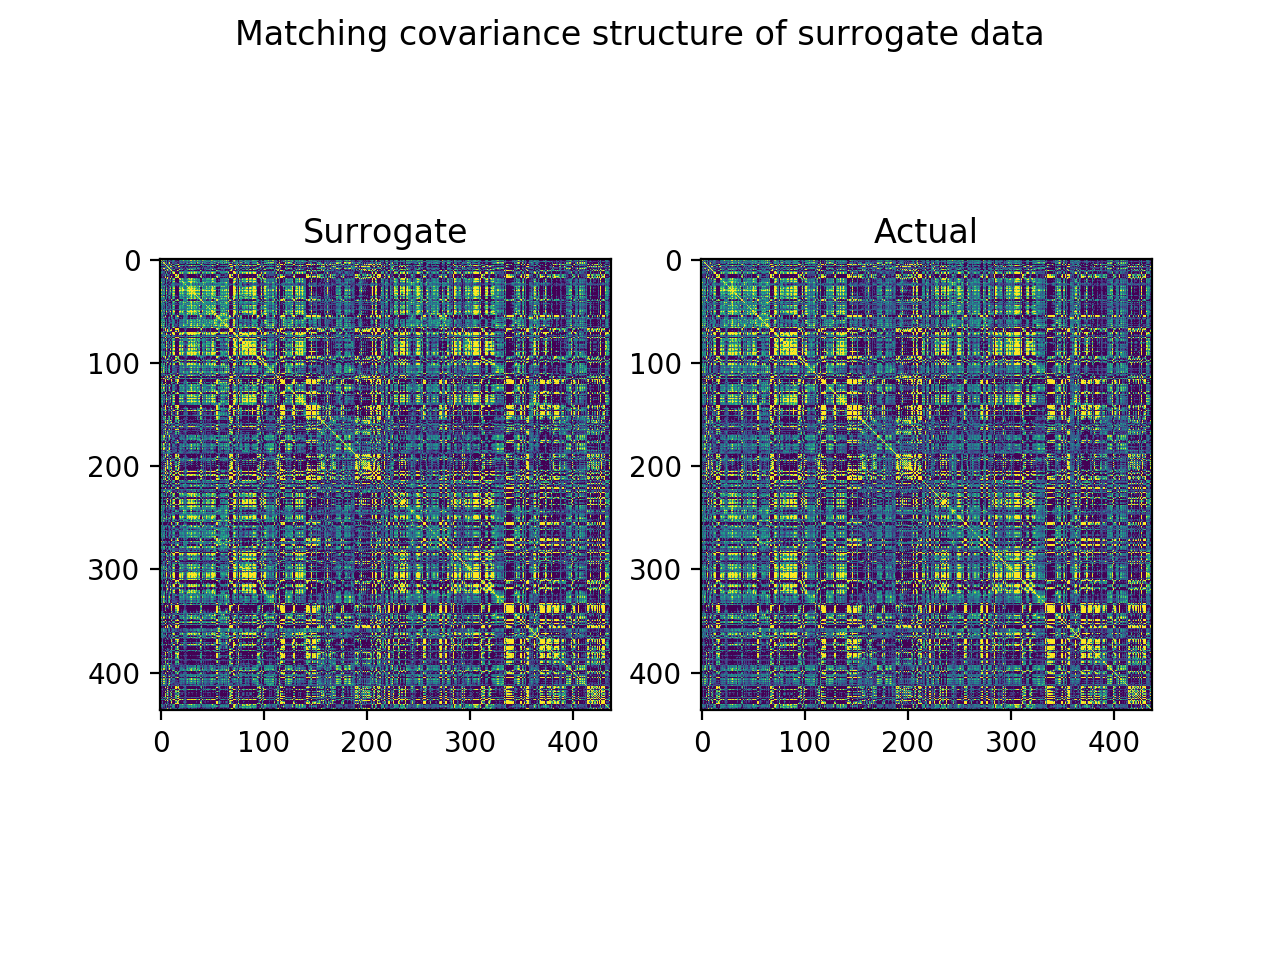

In [4]:
# Verify that the covariance and spectral structure are similar

# Get mean power spectral density across ROIs
p_all = []
for roi in Y[0]:
    ps = np.abs(np.fft.fft(roi))
    p_all.append(ps)
    
pmean_y = np.mean(p_all,axis=0)
freqs_y = np.fft.fftfreq(Y[0].shape[1],1.16) # Sample spacing is TR - 1.16 s
idx = np.argsort(freqs_y)
pmean_y = pmean_y[idx]
freqs_y = freqs_y[idx]

p_all = []
for roi in sessions_clean[0].T:
    ps = np.abs(np.fft.fft(roi))
    p_all.append(ps)

pmean_real = np.mean(p_all,axis=0)
freqs_real = np.fft.fftfreq(sessions_clean[0].shape[0],1.16) # Sample spacing is TR - 1.16 s
idx = np.argsort(freqs_real)
pmean_real = pmean_real[idx]
freqs_real = freqs_real[idx]


# Plot timeseries data
plt.close('all')
plt.figure()
plt.plot(Y[0][0])
plt.plot(sessions_clean[0].T[0])
plt.legend(['Surrogate', 'Actual'])
plt.title('Timeseries of an ROI of surrogate and actual data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot PSDs
plt.figure()
plt.plot(freqs_y,pmean_y)
plt.plot(freqs_real,pmean_real)
plt.legend(['Surrogate', 'Actual'])
plt.title('Matching spectral structure of surrogate data')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.xlim([0,0.2])
plt.show()

# Plot covariance
fig,ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(np.cov(Y[0]),vmin=-1,vmax=3)
ax[1].imshow(C[0],vmin=-1,vmax=3)
ax[0].set_title('Surrogate')
ax[1].set_title('Actual')
plt.suptitle('Matching covariance structure of surrogate data')
plt.show()

### Generate Mapper on the null data

In [32]:
Gs = []
for sess_num,y in enumerate(Y):
    print('Session %d...' % sess_num)
    # Get RSN activations
    df_rsn_bin = get_RSN_act(y.T, sessions[sess_num].atlas)
    # Zscore data
    Xz = scipy.stats.zscore(y.T,axis=0)
    # Run Mapper/DyNeuSR
    results = run_mapper(Xz,df_rsn_bin)
    # Visualize DyNeuGraph
    results['dG'].visualize(path_html='results/null%d.html' % (sess_num+1), show=False, reset=True, static=False, PORT=8800)
    Gs.append(results['G'])

Session 0...


label,group,value,row_count
Cingulo_opercular,0,100,517
DMN,1,110,517
Dorsal_Attention,2,131,517
Frontoparietal 2,3,99,517
Frontoparietal_1,4,98,517
Medial_Parietal,5,129,517
Parieto_occipital,6,122,517
Salience,7,138,517
Somatomotor,8,89,517
Ventral_Attention,9,93,517


[Force Graph] http://localhost:8800/results/null1.html
Session 1...


label,group,value,row_count
Cingulo_opercular,0,99,517
DMN,1,102,517
Dorsal_Attention,2,120,517
Frontoparietal 2,3,84,517
Frontoparietal_1,4,116,517
Medial_Parietal,5,127,517
Parieto_occipital,6,122,517
Salience,7,137,517
Somatomotor,8,104,517
Ventral_Attention,9,98,517


[Force Graph] http://localhost:8800/results/null2.html
Session 2...


label,group,value,row_count
Cingulo_opercular,0,74,517
DMN,1,103,517
Dorsal_Attention,2,131,517
Frontoparietal 2,3,99,517
Frontoparietal_1,4,92,517
Medial_Parietal,5,147,517
Parieto_occipital,6,113,517
Salience,7,148,517
Somatomotor,8,103,517
Ventral_Attention,9,77,517


[Force Graph] http://localhost:8800/results/null3.html
Session 3...


label,group,value,row_count
Cingulo_opercular,0,95,517
DMN,1,109,517
Dorsal_Attention,2,120,517
Frontoparietal 2,3,106,517
Frontoparietal_1,4,107,517
Medial_Parietal,5,125,517
Parieto_occipital,6,97,517
Salience,7,117,517
Somatomotor,8,73,517
Ventral_Attention,9,86,517


[Force Graph] http://localhost:8800/results/null4.html
Session 4...


label,group,value,row_count
Cingulo_opercular,0,102,517
DMN,1,116,517
Dorsal_Attention,2,133,517
Frontoparietal 2,3,93,517
Frontoparietal_1,4,77,517
Medial_Parietal,5,135,517
Parieto_occipital,6,130,517
Salience,7,120,517
Somatomotor,8,57,517
Ventral_Attention,9,73,517


[Force Graph] http://localhost:8800/results/null5.html
Session 5...


label,group,value,row_count
Cingulo_opercular,0,112,517
DMN,1,97,517
Dorsal_Attention,2,123,517
Frontoparietal 2,3,76,517
Frontoparietal_1,4,69,517
Medial_Parietal,5,129,517
Parieto_occipital,6,128,517
Salience,7,114,517
Somatomotor,8,89,517
Ventral_Attention,9,97,517


[Force Graph] http://localhost:8800/results/null6.html
Session 6...


label,group,value,row_count
Cingulo_opercular,0,98,517
DMN,1,87,517
Dorsal_Attention,2,109,517
Frontoparietal 2,3,110,517
Frontoparietal_1,4,103,517
Medial_Parietal,5,150,517
Parieto_occipital,6,114,517
Salience,7,141,517
Somatomotor,8,95,517
Ventral_Attention,9,66,517


[Force Graph] http://localhost:8800/results/null7.html
Session 7...


label,group,value,row_count
Cingulo_opercular,0,101,517
DMN,1,95,517
Dorsal_Attention,2,131,517
Frontoparietal 2,3,93,517
Frontoparietal_1,4,94,517
Medial_Parietal,5,138,517
Parieto_occipital,6,108,517
Salience,7,136,517
Somatomotor,8,85,517
Ventral_Attention,9,73,517


[Force Graph] http://localhost:8800/results/null8.html
Session 8...


label,group,value,row_count
Cingulo_opercular,0,97,517
DMN,1,105,517
Dorsal_Attention,2,133,517
Frontoparietal 2,3,110,517
Frontoparietal_1,4,101,517
Medial_Parietal,5,132,517
Parieto_occipital,6,122,517
Salience,7,124,517
Somatomotor,8,100,517
Ventral_Attention,9,100,517


[Force Graph] http://localhost:8800/results/null9.html
Session 9...


label,group,value,row_count
Cingulo_opercular,0,97,517
DMN,1,94,517
Dorsal_Attention,2,106,517
Frontoparietal 2,3,99,517
Frontoparietal_1,4,91,517
Medial_Parietal,5,119,517
Parieto_occipital,6,102,517
Salience,7,137,517
Somatomotor,8,63,517
Ventral_Attention,9,81,517


[Force Graph] http://localhost:8800/results/null10.html
Session 10...


label,group,value,row_count
Cingulo_opercular,0,115,517
DMN,1,106,517
Dorsal_Attention,2,115,517
Frontoparietal 2,3,97,517
Frontoparietal_1,4,96,517
Medial_Parietal,5,128,517
Parieto_occipital,6,121,517
Salience,7,129,517
Somatomotor,8,97,517
Ventral_Attention,9,94,517


[Force Graph] http://localhost:8800/results/null11.html
Session 11...


label,group,value,row_count
Cingulo_opercular,0,118,517
DMN,1,90,517
Dorsal_Attention,2,111,517
Frontoparietal 2,3,100,517
Frontoparietal_1,4,101,517
Medial_Parietal,5,133,517
Parieto_occipital,6,122,517
Salience,7,130,517
Somatomotor,8,110,517
Ventral_Attention,9,95,517


[Force Graph] http://localhost:8800/results/null12.html
Session 12...


label,group,value,row_count
Cingulo_opercular,0,106,517
DMN,1,101,517
Dorsal_Attention,2,100,517
Frontoparietal 2,3,83,517
Frontoparietal_1,4,110,517
Medial_Parietal,5,133,517
Parieto_occipital,6,122,517
Salience,7,124,517
Somatomotor,8,121,517
Ventral_Attention,9,96,517


[Force Graph] http://localhost:8800/results/null13.html
Session 13...


label,group,value,row_count
Cingulo_opercular,0,109,517
DMN,1,98,517
Dorsal_Attention,2,100,517
Frontoparietal 2,3,94,517
Frontoparietal_1,4,120,517
Medial_Parietal,5,119,517
Parieto_occipital,6,121,517
Salience,7,106,517
Somatomotor,8,83,517
Ventral_Attention,9,103,517


[Force Graph] http://localhost:8800/results/null14.html
Session 14...


label,group,value,row_count
Cingulo_opercular,0,85,517
DMN,1,108,517
Dorsal_Attention,2,131,517
Frontoparietal 2,3,98,517
Frontoparietal_1,4,97,517
Medial_Parietal,5,122,517
Parieto_occipital,6,126,517
Salience,7,114,517
Somatomotor,8,115,517
Ventral_Attention,9,86,517


[Force Graph] http://localhost:8800/results/null15.html
Session 15...


label,group,value,row_count
Cingulo_opercular,0,102,517
DMN,1,108,517
Dorsal_Attention,2,133,517
Frontoparietal 2,3,103,517
Frontoparietal_1,4,96,517
Medial_Parietal,5,119,517
Parieto_occipital,6,113,517
Salience,7,127,517
Somatomotor,8,42,517
Ventral_Attention,9,108,517


[Force Graph] http://localhost:8800/results/null16.html
Session 16...


label,group,value,row_count
Cingulo_opercular,0,111,517
DMN,1,111,517
Dorsal_Attention,2,118,517
Frontoparietal 2,3,96,517
Frontoparietal_1,4,100,517
Medial_Parietal,5,138,517
Parieto_occipital,6,118,517
Salience,7,136,517
Somatomotor,8,123,517
Ventral_Attention,9,101,517


[Force Graph] http://localhost:8800/results/null17.html
Session 17...


label,group,value,row_count
Cingulo_opercular,0,98,517
DMN,1,109,517
Dorsal_Attention,2,126,517
Frontoparietal 2,3,107,517
Frontoparietal_1,4,83,517
Medial_Parietal,5,128,517
Parieto_occipital,6,143,517
Salience,7,132,517
Somatomotor,8,94,517
Ventral_Attention,9,113,517


[Force Graph] http://localhost:8800/results/null18.html
Session 18...


label,group,value,row_count
Cingulo_opercular,0,117,517
DMN,1,112,517
Dorsal_Attention,2,121,517
Frontoparietal 2,3,83,517
Frontoparietal_1,4,64,517
Medial_Parietal,5,127,517
Parieto_occipital,6,138,517
Salience,7,113,517
Somatomotor,8,66,517
Ventral_Attention,9,84,517


[Force Graph] http://localhost:8800/results/null19.html
Session 19...


label,group,value,row_count
Cingulo_opercular,0,100,517
DMN,1,109,517
Dorsal_Attention,2,123,517
Frontoparietal 2,3,97,517
Frontoparietal_1,4,106,517
Medial_Parietal,5,124,517
Parieto_occipital,6,112,517
Salience,7,133,517
Somatomotor,8,77,517
Ventral_Attention,9,100,517


[Force Graph] http://localhost:8800/results/null20.html
Session 20...


label,group,value,row_count
Cingulo_opercular,0,96,517
DMN,1,106,517
Dorsal_Attention,2,106,517
Frontoparietal 2,3,100,517
Frontoparietal_1,4,90,517
Medial_Parietal,5,125,517
Parieto_occipital,6,128,517
Salience,7,120,517
Somatomotor,8,106,517
Ventral_Attention,9,111,517


[Force Graph] http://localhost:8800/results/null21.html
Session 21...


label,group,value,row_count
Cingulo_opercular,0,96,517
DMN,1,108,517
Dorsal_Attention,2,119,517
Frontoparietal 2,3,111,517
Frontoparietal_1,4,79,517
Medial_Parietal,5,140,517
Parieto_occipital,6,134,517
Salience,7,124,517
Somatomotor,8,82,517
Ventral_Attention,9,84,517


[Force Graph] http://localhost:8800/results/null22.html
Session 22...


label,group,value,row_count
Cingulo_opercular,0,97,517
DMN,1,110,517
Dorsal_Attention,2,102,517
Frontoparietal 2,3,112,517
Frontoparietal_1,4,82,517
Medial_Parietal,5,137,517
Parieto_occipital,6,105,517
Salience,7,120,517
Somatomotor,8,97,517
Ventral_Attention,9,112,517


[Force Graph] http://localhost:8800/results/null23.html
Session 23...


label,group,value,row_count
Cingulo_opercular,0,93,517
DMN,1,88,517
Dorsal_Attention,2,148,517
Frontoparietal 2,3,102,517
Frontoparietal_1,4,101,517
Medial_Parietal,5,120,517
Parieto_occipital,6,103,517
Salience,7,116,517
Somatomotor,8,95,517
Ventral_Attention,9,87,517


[Force Graph] http://localhost:8800/results/null24.html
Session 24...


label,group,value,row_count
Cingulo_opercular,0,99,517
DMN,1,96,517
Dorsal_Attention,2,117,517
Frontoparietal 2,3,95,517
Frontoparietal_1,4,94,517
Medial_Parietal,5,124,517
Parieto_occipital,6,137,517
Salience,7,110,517
Somatomotor,8,82,517
Ventral_Attention,9,100,517


[Force Graph] http://localhost:8800/results/null25.html
Session 25...


label,group,value,row_count
Cingulo_opercular,0,92,517
DMN,1,103,517
Dorsal_Attention,2,94,517
Frontoparietal 2,3,96,517
Frontoparietal_1,4,92,517
Medial_Parietal,5,126,517
Parieto_occipital,6,119,517
Salience,7,142,517
Somatomotor,8,106,517
Ventral_Attention,9,87,517


[Force Graph] http://localhost:8800/results/null26.html
Session 26...


label,group,value,row_count
Cingulo_opercular,0,104,517
DMN,1,108,517
Dorsal_Attention,2,106,517
Frontoparietal 2,3,69,517
Frontoparietal_1,4,73,517
Medial_Parietal,5,122,517
Parieto_occipital,6,136,517
Salience,7,129,517
Somatomotor,8,87,517
Ventral_Attention,9,92,517


[Force Graph] http://localhost:8800/results/null27.html
Session 27...


label,group,value,row_count
Cingulo_opercular,0,96,517
DMN,1,127,517
Dorsal_Attention,2,117,517
Frontoparietal 2,3,112,517
Frontoparietal_1,4,86,517
Medial_Parietal,5,127,517
Parieto_occipital,6,117,517
Salience,7,129,517
Somatomotor,8,140,517
Ventral_Attention,9,90,517


[Force Graph] http://localhost:8800/results/null28.html
Session 28...


label,group,value,row_count
Cingulo_opercular,0,94,517
DMN,1,100,517
Dorsal_Attention,2,110,517
Frontoparietal 2,3,92,517
Frontoparietal_1,4,97,517
Medial_Parietal,5,133,517
Parieto_occipital,6,106,517
Salience,7,127,517
Somatomotor,8,112,517
Ventral_Attention,9,117,517


[Force Graph] http://localhost:8800/results/null29.html
Session 29...


label,group,value,row_count
Cingulo_opercular,0,100,517
DMN,1,109,517
Dorsal_Attention,2,128,517
Frontoparietal 2,3,102,517
Frontoparietal_1,4,113,517
Medial_Parietal,5,128,517
Parieto_occipital,6,106,517
Salience,7,129,517
Somatomotor,8,131,517
Ventral_Attention,9,99,517


[Force Graph] http://localhost:8800/results/null30.html
Session 30...


label,group,value,row_count
Cingulo_opercular,0,90,517
DMN,1,79,517
Dorsal_Attention,2,103,517
Frontoparietal 2,3,98,517
Frontoparietal_1,4,98,517
Medial_Parietal,5,127,517
Parieto_occipital,6,114,517
Salience,7,116,517
Somatomotor,8,107,517
Ventral_Attention,9,100,517


[Force Graph] http://localhost:8800/results/null31.html
Session 31...


label,group,value,row_count
Cingulo_opercular,0,92,517
DMN,1,122,517
Dorsal_Attention,2,126,517
Frontoparietal 2,3,104,517
Frontoparietal_1,4,105,517
Medial_Parietal,5,120,517
Parieto_occipital,6,109,517
Salience,7,123,517
Somatomotor,8,85,517
Ventral_Attention,9,94,517


[Force Graph] http://localhost:8800/results/null32.html
Session 32...


label,group,value,row_count
Cingulo_opercular,0,92,517
DMN,1,102,517
Dorsal_Attention,2,128,517
Frontoparietal 2,3,98,517
Frontoparietal_1,4,89,517
Medial_Parietal,5,144,517
Parieto_occipital,6,116,517
Salience,7,131,517
Somatomotor,8,128,517
Ventral_Attention,9,104,517


[Force Graph] http://localhost:8800/results/null33.html
Session 33...


label,group,value,row_count
Cingulo_opercular,0,83,517
DMN,1,112,517
Dorsal_Attention,2,113,517
Frontoparietal 2,3,78,517
Frontoparietal_1,4,89,517
Medial_Parietal,5,120,517
Parieto_occipital,6,124,517
Salience,7,139,517
Somatomotor,8,121,517
Ventral_Attention,9,84,517


[Force Graph] http://localhost:8800/results/null34.html
Session 34...


label,group,value,row_count
Cingulo_opercular,0,95,517
DMN,1,105,517
Dorsal_Attention,2,96,517
Frontoparietal 2,3,90,517
Frontoparietal_1,4,78,517
Medial_Parietal,5,135,517
Parieto_occipital,6,123,517
Salience,7,136,517
Somatomotor,8,106,517
Ventral_Attention,9,89,517


[Force Graph] http://localhost:8800/results/null35.html
Session 35...


label,group,value,row_count
Cingulo_opercular,0,106,517
DMN,1,106,517
Dorsal_Attention,2,95,517
Frontoparietal 2,3,105,517
Frontoparietal_1,4,106,517
Medial_Parietal,5,126,517
Parieto_occipital,6,135,517
Salience,7,122,517
Somatomotor,8,102,517
Ventral_Attention,9,102,517


[Force Graph] http://localhost:8800/results/null36.html
Session 36...


label,group,value,row_count
Cingulo_opercular,0,97,517
DMN,1,88,517
Dorsal_Attention,2,125,517
Frontoparietal 2,3,103,517
Frontoparietal_1,4,88,517
Medial_Parietal,5,126,517
Parieto_occipital,6,136,517
Salience,7,132,517
Somatomotor,8,120,517
Ventral_Attention,9,105,517


[Force Graph] http://localhost:8800/results/null37.html
Session 37...


label,group,value,row_count
Cingulo_opercular,0,106,517
DMN,1,124,517
Dorsal_Attention,2,125,517
Frontoparietal 2,3,107,517
Frontoparietal_1,4,82,517
Medial_Parietal,5,130,517
Parieto_occipital,6,137,517
Salience,7,124,517
Somatomotor,8,85,517
Ventral_Attention,9,95,517


[Force Graph] http://localhost:8800/results/null38.html
Session 38...


label,group,value,row_count
Cingulo_opercular,0,107,517
DMN,1,99,517
Dorsal_Attention,2,138,517
Frontoparietal 2,3,102,517
Frontoparietal_1,4,93,517
Medial_Parietal,5,125,517
Parieto_occipital,6,130,517
Salience,7,111,517
Somatomotor,8,60,517
Ventral_Attention,9,109,517


[Force Graph] http://localhost:8800/results/null39.html
Session 39...


label,group,value,row_count
Cingulo_opercular,0,98,517
DMN,1,106,517
Dorsal_Attention,2,111,517
Frontoparietal 2,3,124,517
Frontoparietal_1,4,82,517
Medial_Parietal,5,133,517
Parieto_occipital,6,132,517
Salience,7,123,517
Somatomotor,8,97,517
Ventral_Attention,9,109,517


[Force Graph] http://localhost:8800/results/null40.html
Session 40...


label,group,value,row_count
Cingulo_opercular,0,91,517
DMN,1,100,517
Dorsal_Attention,2,97,517
Frontoparietal 2,3,99,517
Frontoparietal_1,4,91,517
Medial_Parietal,5,120,517
Parieto_occipital,6,120,517
Salience,7,133,517
Somatomotor,8,105,517
Ventral_Attention,9,101,517


[Force Graph] http://localhost:8800/results/null41.html
Session 41...


label,group,value,row_count
Cingulo_opercular,0,67,517
DMN,1,98,517
Dorsal_Attention,2,118,517
Frontoparietal 2,3,115,517
Frontoparietal_1,4,115,517
Medial_Parietal,5,131,517
Parieto_occipital,6,141,517
Salience,7,128,517
Somatomotor,8,113,517
Ventral_Attention,9,105,517


[Force Graph] http://localhost:8800/results/null42.html
Session 42...


label,group,value,row_count
Cingulo_opercular,0,86,517
DMN,1,104,517
Dorsal_Attention,2,108,517
Frontoparietal 2,3,113,517
Frontoparietal_1,4,98,517
Medial_Parietal,5,119,517
Parieto_occipital,6,118,517
Salience,7,137,517
Somatomotor,8,110,517
Ventral_Attention,9,103,517


[Force Graph] http://localhost:8800/results/null43.html
Session 43...


label,group,value,row_count
Cingulo_opercular,0,94,517
DMN,1,102,517
Dorsal_Attention,2,120,517
Frontoparietal 2,3,108,517
Frontoparietal_1,4,99,517
Medial_Parietal,5,131,517
Parieto_occipital,6,112,517
Salience,7,122,517
Somatomotor,8,126,517
Ventral_Attention,9,104,517


[Force Graph] http://localhost:8800/results/null44.html
Session 44...


label,group,value,row_count
Cingulo_opercular,0,108,517
DMN,1,93,517
Dorsal_Attention,2,101,517
Frontoparietal 2,3,112,517
Frontoparietal_1,4,85,517
Medial_Parietal,5,138,517
Parieto_occipital,6,136,517
Salience,7,114,517
Somatomotor,8,116,517
Ventral_Attention,9,88,517


[Force Graph] http://localhost:8800/results/null45.html
Session 45...


label,group,value,row_count
Cingulo_opercular,0,106,517
DMN,1,100,517
Dorsal_Attention,2,121,517
Frontoparietal 2,3,93,517
Frontoparietal_1,4,86,517
Medial_Parietal,5,147,517
Parieto_occipital,6,113,517
Salience,7,127,517
Somatomotor,8,126,517
Ventral_Attention,9,125,517


[Force Graph] http://localhost:8800/results/null46.html
Session 46...


label,group,value,row_count
Cingulo_opercular,0,89,517
DMN,1,102,517
Dorsal_Attention,2,112,517
Frontoparietal 2,3,95,517
Frontoparietal_1,4,108,517
Medial_Parietal,5,140,517
Parieto_occipital,6,138,517
Salience,7,123,517
Somatomotor,8,123,517
Ventral_Attention,9,105,517


[Force Graph] http://localhost:8800/results/null47.html
Session 47...


label,group,value,row_count
Cingulo_opercular,0,93,517
DMN,1,108,517
Dorsal_Attention,2,120,517
Frontoparietal 2,3,110,517
Frontoparietal_1,4,100,517
Medial_Parietal,5,138,517
Parieto_occipital,6,139,517
Salience,7,139,517
Somatomotor,8,122,517
Ventral_Attention,9,86,517


[Force Graph] http://localhost:8800/results/null48.html
Session 48...


label,group,value,row_count
Cingulo_opercular,0,121,517
DMN,1,97,517
Dorsal_Attention,2,115,517
Frontoparietal 2,3,81,517
Frontoparietal_1,4,103,517
Medial_Parietal,5,133,517
Parieto_occipital,6,117,517
Salience,7,136,517
Somatomotor,8,114,517
Ventral_Attention,9,81,517


[Force Graph] http://localhost:8800/results/null49.html
Session 49...


label,group,value,row_count
Cingulo_opercular,0,100,517
DMN,1,97,517
Dorsal_Attention,2,122,517
Frontoparietal 2,3,110,517
Frontoparietal_1,4,106,517
Medial_Parietal,5,129,517
Parieto_occipital,6,110,517
Salience,7,125,517
Somatomotor,8,115,517
Ventral_Attention,9,103,517


[Force Graph] http://localhost:8800/results/null50.html
Session 50...


label,group,value,row_count
Cingulo_opercular,0,85,517
DMN,1,104,517
Dorsal_Attention,2,104,517
Frontoparietal 2,3,130,517
Frontoparietal_1,4,92,517
Medial_Parietal,5,111,517
Parieto_occipital,6,110,517
Salience,7,109,517
Somatomotor,8,113,517
Ventral_Attention,9,94,517


[Force Graph] http://localhost:8800/results/null51.html
Session 51...


label,group,value,row_count
Cingulo_opercular,0,86,517
DMN,1,101,517
Dorsal_Attention,2,132,517
Frontoparietal 2,3,111,517
Frontoparietal_1,4,81,517
Medial_Parietal,5,125,517
Parieto_occipital,6,136,517
Salience,7,122,517
Somatomotor,8,120,517
Ventral_Attention,9,102,517


[Force Graph] http://localhost:8800/results/null52.html
Session 52...


label,group,value,row_count
Cingulo_opercular,0,100,517
DMN,1,99,517
Dorsal_Attention,2,116,517
Frontoparietal 2,3,107,517
Frontoparietal_1,4,111,517
Medial_Parietal,5,123,517
Parieto_occipital,6,121,517
Salience,7,139,517
Somatomotor,8,100,517
Ventral_Attention,9,112,517


[Force Graph] http://localhost:8800/results/null53.html
Session 53...


label,group,value,row_count
Cingulo_opercular,0,87,517
DMN,1,101,517
Dorsal_Attention,2,117,517
Frontoparietal 2,3,115,517
Frontoparietal_1,4,82,517
Medial_Parietal,5,127,517
Parieto_occipital,6,123,517
Salience,7,113,517
Somatomotor,8,114,517
Ventral_Attention,9,83,517


[Force Graph] http://localhost:8800/results/null54.html
Session 54...


label,group,value,row_count
Cingulo_opercular,0,99,517
DMN,1,122,517
Dorsal_Attention,2,115,517
Frontoparietal 2,3,101,517
Frontoparietal_1,4,96,517
Medial_Parietal,5,133,517
Parieto_occipital,6,111,517
Salience,7,139,517
Somatomotor,8,117,517
Ventral_Attention,9,96,517


[Force Graph] http://localhost:8800/results/null55.html
Session 55...


label,group,value,row_count
Cingulo_opercular,0,85,517
DMN,1,112,517
Dorsal_Attention,2,105,517
Frontoparietal 2,3,120,517
Frontoparietal_1,4,94,517
Medial_Parietal,5,156,517
Parieto_occipital,6,128,517
Salience,7,114,517
Somatomotor,8,97,517
Ventral_Attention,9,96,517


[Force Graph] http://localhost:8800/results/null56.html
Session 56...


label,group,value,row_count
Cingulo_opercular,0,105,517
DMN,1,94,517
Dorsal_Attention,2,129,517
Frontoparietal 2,3,84,517
Frontoparietal_1,4,106,517
Medial_Parietal,5,135,517
Parieto_occipital,6,123,517
Salience,7,127,517
Somatomotor,8,102,517
Ventral_Attention,9,106,517


[Force Graph] http://localhost:8800/results/null57.html
Session 57...


label,group,value,row_count
Cingulo_opercular,0,86,517
DMN,1,104,517
Dorsal_Attention,2,121,517
Frontoparietal 2,3,125,517
Frontoparietal_1,4,89,517
Medial_Parietal,5,131,517
Parieto_occipital,6,138,517
Salience,7,113,517
Somatomotor,8,119,517
Ventral_Attention,9,112,517


[Force Graph] http://localhost:8800/results/null58.html
Session 58...


label,group,value,row_count
Cingulo_opercular,0,97,517
DMN,1,111,517
Dorsal_Attention,2,120,517
Frontoparietal 2,3,108,517
Frontoparietal_1,4,100,517
Medial_Parietal,5,133,517
Parieto_occipital,6,129,517
Salience,7,135,517
Somatomotor,8,103,517
Ventral_Attention,9,122,517


[Force Graph] http://localhost:8800/results/null59.html
Session 59...


label,group,value,row_count
Cingulo_opercular,0,103,517
DMN,1,107,517
Dorsal_Attention,2,118,517
Frontoparietal 2,3,109,517
Frontoparietal_1,4,103,517
Medial_Parietal,5,158,517
Parieto_occipital,6,117,517
Salience,7,131,517
Somatomotor,8,105,517
Ventral_Attention,9,118,517


[Force Graph] http://localhost:8800/results/null60.html
Session 60...


label,group,value,row_count
Cingulo_opercular,0,96,517
DMN,1,99,517
Dorsal_Attention,2,113,517
Frontoparietal 2,3,92,517
Frontoparietal_1,4,93,517
Medial_Parietal,5,137,517
Parieto_occipital,6,120,517
Salience,7,115,517
Somatomotor,8,116,517
Ventral_Attention,9,100,517


[Force Graph] http://localhost:8800/results/null61.html
Session 61...


label,group,value,row_count
Cingulo_opercular,0,104,517
DMN,1,107,517
Dorsal_Attention,2,130,517
Frontoparietal 2,3,99,517
Frontoparietal_1,4,97,517
Medial_Parietal,5,125,517
Parieto_occipital,6,123,517
Salience,7,122,517
Somatomotor,8,112,517
Ventral_Attention,9,101,517


[Force Graph] http://localhost:8800/results/null62.html
Session 62...


label,group,value,row_count
Cingulo_opercular,0,98,517
DMN,1,90,517
Dorsal_Attention,2,116,517
Frontoparietal 2,3,109,517
Frontoparietal_1,4,100,517
Medial_Parietal,5,132,517
Parieto_occipital,6,142,517
Salience,7,133,517
Somatomotor,8,106,517
Ventral_Attention,9,101,517


[Force Graph] http://localhost:8800/results/null63.html
Session 63...


label,group,value,row_count
Cingulo_opercular,0,84,517
DMN,1,95,517
Dorsal_Attention,2,118,517
Frontoparietal 2,3,105,517
Frontoparietal_1,4,89,517
Medial_Parietal,5,131,517
Parieto_occipital,6,128,517
Salience,7,124,517
Somatomotor,8,55,517
Ventral_Attention,9,102,517


[Force Graph] http://localhost:8800/results/null64.html
Session 64...


label,group,value,row_count
Cingulo_opercular,0,112,517
DMN,1,79,517
Dorsal_Attention,2,104,517
Frontoparietal 2,3,96,517
Frontoparietal_1,4,84,517
Medial_Parietal,5,144,517
Parieto_occipital,6,133,517
Salience,7,122,517
Somatomotor,8,114,517
Ventral_Attention,9,90,517


[Force Graph] http://localhost:8800/results/null65.html
Session 65...


label,group,value,row_count
Cingulo_opercular,0,106,517
DMN,1,112,517
Dorsal_Attention,2,144,517
Frontoparietal 2,3,100,517
Frontoparietal_1,4,94,517
Medial_Parietal,5,130,517
Parieto_occipital,6,134,517
Salience,7,124,517
Somatomotor,8,104,517
Ventral_Attention,9,92,517


[Force Graph] http://localhost:8800/results/null66.html
Session 66...


label,group,value,row_count
Cingulo_opercular,0,78,517
DMN,1,94,517
Dorsal_Attention,2,103,517
Frontoparietal 2,3,111,517
Frontoparietal_1,4,95,517
Medial_Parietal,5,138,517
Parieto_occipital,6,119,517
Salience,7,130,517
Somatomotor,8,128,517
Ventral_Attention,9,118,517


[Force Graph] http://localhost:8800/results/null67.html
Session 67...


label,group,value,row_count
Cingulo_opercular,0,99,517
DMN,1,108,517
Dorsal_Attention,2,115,517
Frontoparietal 2,3,102,517
Frontoparietal_1,4,97,517
Medial_Parietal,5,139,517
Parieto_occipital,6,125,517
Salience,7,120,517
Somatomotor,8,92,517
Ventral_Attention,9,129,517


[Force Graph] http://localhost:8800/results/null68.html
Session 68...


label,group,value,row_count
Cingulo_opercular,0,99,517
DMN,1,97,517
Dorsal_Attention,2,123,517
Frontoparietal 2,3,106,517
Frontoparietal_1,4,101,517
Medial_Parietal,5,126,517
Parieto_occipital,6,107,517
Salience,7,119,517
Somatomotor,8,123,517
Ventral_Attention,9,98,517


[Force Graph] http://localhost:8800/results/null69.html
Session 69...


label,group,value,row_count
Cingulo_opercular,0,97,517
DMN,1,103,517
Dorsal_Attention,2,135,517
Frontoparietal 2,3,102,517
Frontoparietal_1,4,90,517
Medial_Parietal,5,133,517
Parieto_occipital,6,116,517
Salience,7,113,517
Somatomotor,8,110,517
Ventral_Attention,9,115,517


[Force Graph] http://localhost:8800/results/null70.html
Session 70...


label,group,value,row_count
Cingulo_opercular,0,105,517
DMN,1,92,517
Dorsal_Attention,2,124,517
Frontoparietal 2,3,99,517
Frontoparietal_1,4,95,517
Medial_Parietal,5,134,517
Parieto_occipital,6,134,517
Salience,7,127,517
Somatomotor,8,72,517
Ventral_Attention,9,90,517


[Force Graph] http://localhost:8800/results/null71.html
Session 71...


label,group,value,row_count
Cingulo_opercular,0,102,517
DMN,1,104,517
Dorsal_Attention,2,122,517
Frontoparietal 2,3,98,517
Frontoparietal_1,4,91,517
Medial_Parietal,5,140,517
Parieto_occipital,6,98,517
Salience,7,117,517
Somatomotor,8,125,517
Ventral_Attention,9,93,517


[Force Graph] http://localhost:8800/results/null72.html
Session 72...


label,group,value,row_count
Cingulo_opercular,0,88,517
DMN,1,98,517
Dorsal_Attention,2,125,517
Frontoparietal 2,3,113,517
Frontoparietal_1,4,76,517
Medial_Parietal,5,129,517
Parieto_occipital,6,131,517
Salience,7,135,517
Somatomotor,8,82,517
Ventral_Attention,9,109,517


[Force Graph] http://localhost:8800/results/null73.html
Session 73...


label,group,value,row_count
Cingulo_opercular,0,103,517
DMN,1,102,517
Dorsal_Attention,2,128,517
Frontoparietal 2,3,101,517
Frontoparietal_1,4,104,517
Medial_Parietal,5,119,517
Parieto_occipital,6,98,517
Salience,7,132,517
Somatomotor,8,109,517
Ventral_Attention,9,94,517


[Force Graph] http://localhost:8800/results/null74.html
Session 74...


label,group,value,row_count
Cingulo_opercular,0,117,517
DMN,1,90,517
Dorsal_Attention,2,108,517
Frontoparietal 2,3,102,517
Frontoparietal_1,4,99,517
Medial_Parietal,5,126,517
Parieto_occipital,6,120,517
Salience,7,133,517
Somatomotor,8,127,517
Ventral_Attention,9,84,517


[Force Graph] http://localhost:8800/results/null75.html
Session 75...


label,group,value,row_count
Cingulo_opercular,0,104,517
DMN,1,116,517
Dorsal_Attention,2,133,517
Frontoparietal 2,3,89,517
Frontoparietal_1,4,95,517
Medial_Parietal,5,132,517
Parieto_occipital,6,130,517
Salience,7,115,517
Somatomotor,8,63,517
Ventral_Attention,9,89,517


[Force Graph] http://localhost:8800/results/null76.html
Session 76...


label,group,value,row_count
Cingulo_opercular,0,109,517
DMN,1,100,517
Dorsal_Attention,2,137,517
Frontoparietal 2,3,106,517
Frontoparietal_1,4,96,517
Medial_Parietal,5,125,517
Parieto_occipital,6,133,517
Salience,7,138,517
Somatomotor,8,119,517
Ventral_Attention,9,100,517


[Force Graph] http://localhost:8800/results/null77.html
Session 77...


label,group,value,row_count
Cingulo_opercular,0,101,517
DMN,1,103,517
Dorsal_Attention,2,118,517
Frontoparietal 2,3,105,517
Frontoparietal_1,4,80,517
Medial_Parietal,5,134,517
Parieto_occipital,6,135,517
Salience,7,134,517
Somatomotor,8,104,517
Ventral_Attention,9,104,517


[Force Graph] http://localhost:8800/results/null78.html
Session 78...


label,group,value,row_count
Cingulo_opercular,0,103,517
DMN,1,84,517
Dorsal_Attention,2,115,517
Frontoparietal 2,3,118,517
Frontoparietal_1,4,119,517
Medial_Parietal,5,137,517
Parieto_occipital,6,112,517
Salience,7,140,517
Somatomotor,8,126,517
Ventral_Attention,9,91,517


[Force Graph] http://localhost:8800/results/null79.html
Session 79...


label,group,value,row_count
Cingulo_opercular,0,110,517
DMN,1,102,517
Dorsal_Attention,2,128,517
Frontoparietal 2,3,101,517
Frontoparietal_1,4,111,517
Medial_Parietal,5,153,517
Parieto_occipital,6,108,517
Salience,7,128,517
Somatomotor,8,111,517
Ventral_Attention,9,83,517


[Force Graph] http://localhost:8800/results/null80.html
Session 80...


label,group,value,row_count
Cingulo_opercular,0,81,517
DMN,1,88,517
Dorsal_Attention,2,117,517
Frontoparietal 2,3,102,517
Frontoparietal_1,4,86,517
Medial_Parietal,5,129,517
Parieto_occipital,6,127,517
Salience,7,134,517
Somatomotor,8,124,517
Ventral_Attention,9,106,517


[Force Graph] http://localhost:8800/results/null81.html
Session 81...


label,group,value,row_count
Cingulo_opercular,0,75,517
DMN,1,99,517
Dorsal_Attention,2,144,517
Frontoparietal 2,3,101,517
Frontoparietal_1,4,101,517
Medial_Parietal,5,128,517
Parieto_occipital,6,127,517
Salience,7,119,517
Somatomotor,8,74,517
Ventral_Attention,9,89,517


[Force Graph] http://localhost:8800/results/null82.html
Session 82...


label,group,value,row_count
Cingulo_opercular,0,112,517
DMN,1,115,517
Dorsal_Attention,2,151,517
Frontoparietal 2,3,102,517
Frontoparietal_1,4,111,517
Medial_Parietal,5,138,517
Parieto_occipital,6,125,517
Salience,7,124,517
Somatomotor,8,80,517
Ventral_Attention,9,86,517


[Force Graph] http://localhost:8800/results/null83.html
Session 83...


label,group,value,row_count
Cingulo_opercular,0,98,517
DMN,1,94,517
Dorsal_Attention,2,114,517
Frontoparietal 2,3,82,517
Frontoparietal_1,4,87,517
Medial_Parietal,5,138,517
Parieto_occipital,6,137,517
Salience,7,111,517
Somatomotor,8,118,517
Ventral_Attention,9,89,517


[Force Graph] http://localhost:8800/results/null84.html


In [33]:
import pickle

with open('null_graphs.p', 'wb') as f:
    pickle.dump(Gs,f)

### Characterize graph structure of null vs real

Seemingly, the null models have less connected graphs than the real. What are ways we can characterize this? Mayb clustering coefficient, fraction of nodes in largest component, degree distribution...

In [34]:
import pickle

with open('nx_graphs.p', 'rb') as f:
    Greals = pickle.load(f)
with open('null_graphs.p', 'rb') as f:
    Gnulls = pickle.load(f)

#### Largest component

<IPython.core.display.Javascript object>


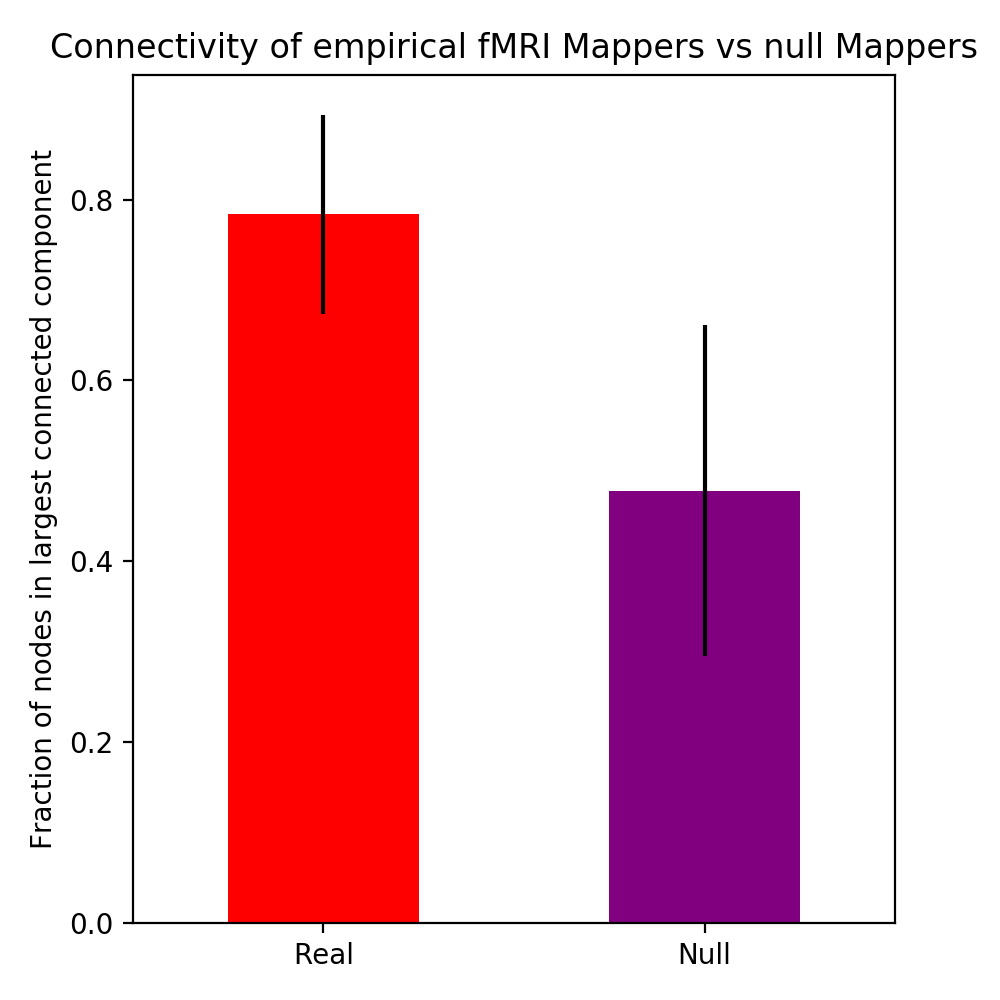

p-value: 3.2201e-27


In [35]:
import networkx as nx
from scipy.stats import ttest_ind

giant_fraction_real = []
giant_fraction_null = []
for Gr,Gn in zip(Greals,Gnulls):
    # Get largest component
    Ggiantr = [Gr.subgraph(c) for c in sorted(nx.connected_components(Gr), key=len, reverse=True)][0]
    Ggiantn = [Gn.subgraph(c) for c in sorted(nx.connected_components(Gn), key=len, reverse=True)][0]
    # Calculate fraction out of all nodes
    Gfracr = float(len(Ggiantr.nodes())) / float(len(Gr.nodes()))
    Gfracn = float(len(Ggiantn.nodes())) / float(len(Gn.nodes()))
    
    giant_fraction_real.append(Gfracr)
    giant_fraction_null.append(Gfracn)

# Calculate mean and std
gmeanr = np.mean(giant_fraction_real)
gstdr = np.std(giant_fraction_real)
gmeann = np.mean(giant_fraction_null)
gstdn = np.std(giant_fraction_null)

# Plot
plt.close('all')
plt.bar([1,2],[gmeanr,gmeann], yerr=[gstdr,gstdn], color=['red','purple'], width=0.5)
plt.xlim([0.5,2.5])
plt.xticks([1,2],['Real','Null'])
plt.ylabel('Fraction of nodes in largest connected component')
plt.title('Connectivity of empirical fMRI Mappers vs null Mappers')
fig = plt.gcf()
fig.set_size_inches(5,5)
fig.tight_layout()
plt.show()

# Print significance
t,p = ttest_ind(giant_fraction_real,giant_fraction_null)
print('p-value: %.5g' % p)

#### Clustering coefficient

<IPython.core.display.Javascript object>


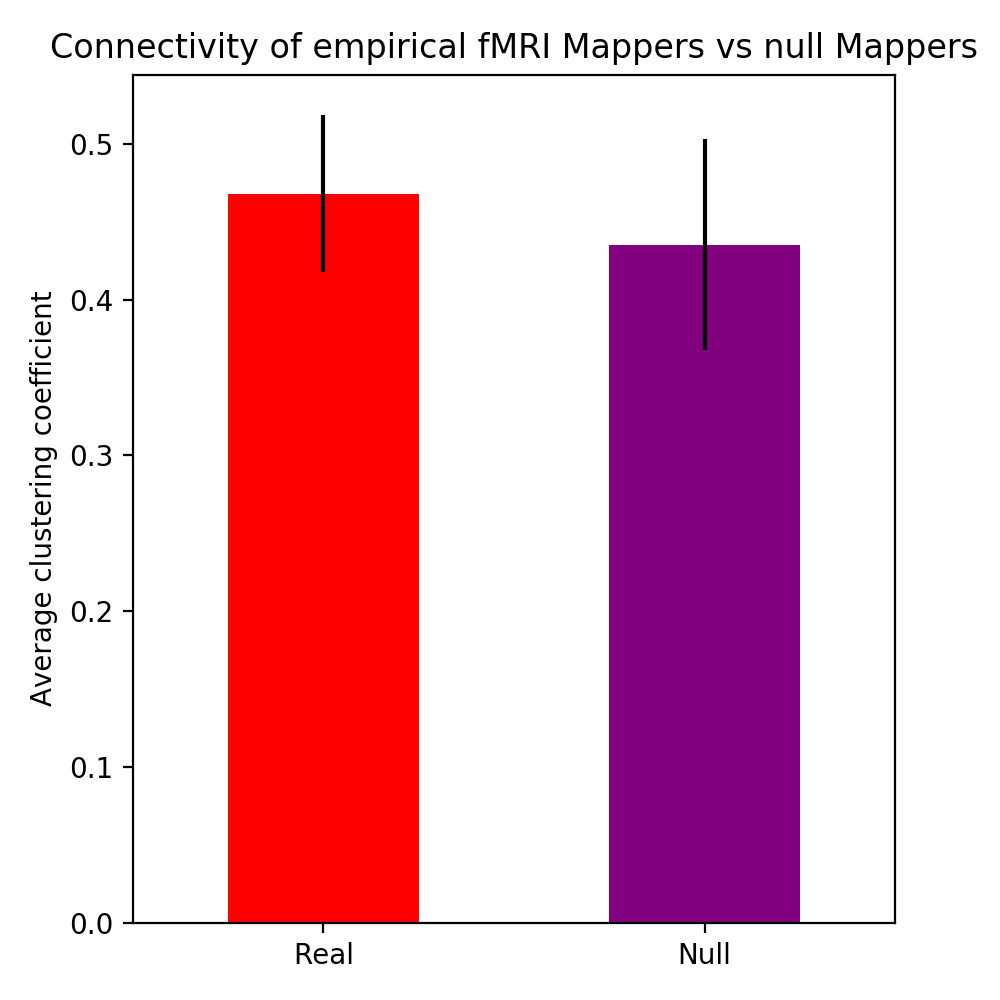

p-value: 0.00055004


In [36]:
import networkx as nx
from scipy.stats import ttest_ind

Creal = [nx.average_clustering(G) for G in Greals]
Cnull = [nx.average_clustering(G) for G in Gnulls]

# Calculate mean and std
cmeanr = np.mean(Creal)
cstdr = np.std(Creal)
cmeann = np.mean(Cnull)
cstdn = np.std(Cnull)

# Plot
plt.close('all')
plt.bar([1,2],[cmeanr,cmeann], yerr=[cstdr,cstdn], color=['red','purple'], width=0.5)
plt.xlim([0.5,2.5])
plt.xticks([1,2],['Real','Null'])
plt.ylabel('Average clustering coefficient')
plt.title('Connectivity of empirical fMRI Mappers vs null Mappers')
fig = plt.gcf()
fig.set_size_inches(5,5)
fig.tight_layout()
plt.show()

# Print significance
t,p = ttest_ind(Creal,Cnull)
print('p-value: %.5g' % p)

#### Degree Distribution

<IPython.core.display.Javascript object>


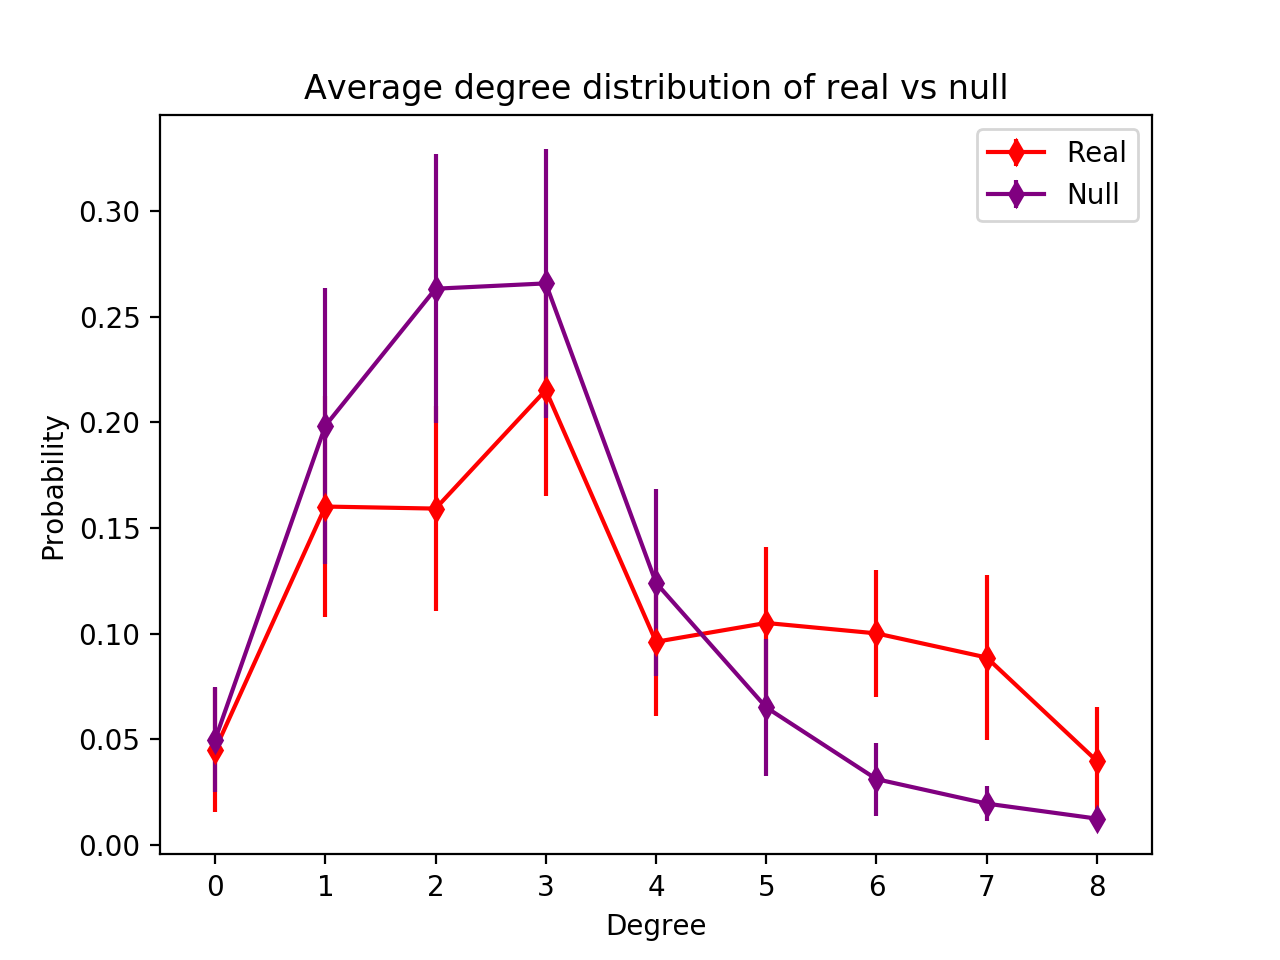

In [37]:
import collections

alldegr = collections.defaultdict(list)
alldegn = collections.defaultdict(list)
for Gr, Gn in zip(Greals, Gnulls): 
    degree_sequence = sorted([d for n, d in Gr.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    # Convert to probabilities
    total_cnt = float(sum(cnt))
    p = [el / total_cnt for el in cnt]
    for ind,d in enumerate(deg):
        alldegr[d].append(p[ind])
        
    degree_sequence = sorted([d for n, d in Gn.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    # Convert to probabilities
    total_cnt = float(sum(cnt))
    p = [el / total_cnt for el in cnt]
    for ind,d in enumerate(deg):
        alldegn[d].append(p[ind])

# Calculate mean probabilities and std
pmeanr = [np.mean(alldegr[d]) for d in sorted(alldegr.keys())]
pstdr = [np.std(alldegr[d]) for d in sorted(alldegr.keys())]
pmeann = [np.mean(alldegn[d]) for d in sorted(alldegn.keys())]
pstdn = [np.std(alldegn[d]) for d in sorted(alldegn.keys())]

# Plot distribution
plt.close('all')
plt.xlim([min(sorted(alldegr.keys()))-0.5,max(sorted(alldegr.keys()))+0.5])
plt.xticks(np.linspace(min(sorted(alldegr.keys())),max(sorted(alldegr.keys())),len(list(alldegr.keys()))))
plt.errorbar(sorted(alldegr.keys()), pmeanr, yerr=pstdr, color='r', fmt='-d')
plt.errorbar(sorted(alldegn.keys()), pmeann, yerr=pstdn, color='purple', fmt='-d')
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Average degree distribution of real vs null')
plt.legend(['Real','Null'])
plt.show()

#### Community Structure

In [38]:
# Get largest connected components
Ggiants_real = []
Ggiants_null = []
for Gr, Gn in zip(Greals,Gnulls):
    Ggiantr = [Gr.subgraph(c) for c in sorted(nx.connected_components(Gr), key=len, reverse=True)][0]
    Ggiantn = [Gn.subgraph(c) for c in sorted(nx.connected_components(Gn), key=len, reverse=True)][0]
    Ggiants_real.append(Ggiantr)
    Ggiants_null.append(Ggiantn)

In [48]:
import community

def plot_communities(Garray, sess_num=-1):
    # Generate colormap
    cmap = plt.get_cmap('jet',13)
    colordict = {'Default Mode' : 0,
                     'Dorsal Attention' : 1,
                     'Ventral Attention' : 2,
                     'Fronto-parietal 1' : 3,
                     'Cingulo-opercular' : 4,
                     'Salience' : 5,
                     'Somatomotor' : 6,
                     'Visual 2' : 7,
                     'Medial Parietal' : 8,
                     'Parietal Occipital' : 9,
                     'Fronto-parietal 2' : 10,
                     'Visual 1' : 11,
                     'none' : 12}

    plt.close('all')
    fig,ax = plt.subplots(nrows=1,figsize=(8,4))
    for i,G in enumerate(Garray):
        if sess_num != -1:
            if i != sess_num-1: continue
    #     # Get subject id
    #     subid = sessions[i].y[0][1][:-4]
    #     # Get day of week - Tuesday is fasted, Thursday is fed
    #     try:
    #         day = int(df_behavior[df_behavior['subcode'] == subid]['day_of_week'])
    #     except ValueError:
    #         continue
    #     if day == 2:
    #         state = 'fed'
    #     elif day == 4:
    #         state = 'fasted'
    #     else:
    #         continue
        partition = dict()
        # Get proportions
        props = nx.get_node_attributes(G,'proportions')
        # Iterate through each node and get most common network activation
        for p in props.keys():
            # Pull out the dicts for each network - result will be a list of lists of dicts (jesus christ)
            nws = list(props[p].values())[:-2]
            # Pull out the values for network activations if group == 1, else it's a 0
            nwtotals = [dic['value'] if dic['group'] == 1 else 0 if len(dictlist) == 1 else -1 for dictlist in nws for dic in dictlist]
            # Remove the -1s
            nwtotals = [el for el in nwtotals if el != -1]
            # Get indices of max values
            highestnws = np.argwhere(nwtotals == np.max(nwtotals))[0]
            # Randomly choose the highest network
            nwlabel = np.random.choice(np.array(list(props[p].keys()))[highestnws])

            partition[p] = nwlabel

        Q = community.modularity(partition,G)


        size = len(set(partition.values()))


        pos = nx.kamada_kawai_layout(G)
        print(partition.values())
        for com in set(partition.values()) :
            list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
            nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 60, node_color = cmap(colordict[com]), edgecolors = 'k',ax=ax)

        nx.draw_networkx_edges(G, pos, alpha=1.0, ax=ax)
        ax.axis('off')

        # Create text box
        ax.set_title('Q = %.2f' % Q)
        norm = mpl.colors.Normalize(vmin=0,vmax=1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ticks=np.linspace(0,1,13), ax = ax)
        cbar.ax.set_yticklabels(rsns)



    plt.show()


### Generate Mappers on null data in anatomical space

In [8]:
roi2rsn = np.array(sessions[0].atlas['data']['network'])
RSNs = list(set(roi2rsn))
df_roi_rsn = pd.DataFrame(0,index=np.arange(sessions[0].X.shape[1]),columns=RSNs)
for ind,roi in enumerate(roi2rsn):
    df_roi_rsn.loc[ind,roi] = 1

In [10]:
Gs = []
for sess_num,y in enumerate(Y):
    print('Session %d...' % sess_num)
    # Zscore data
    Xz = scipy.stats.zscore(y,axis=1)
    # Run Mapper/DyNeuSR
    results = run_mapper(Xz,df_roi_rsn,cover=km.Cover(6, 0.67))
    # Visualize DyNeuGraph
    results['dG'].visualize(path_html='results/null%d_spatial.html' % (sess_num+1), show=False, reset=True, static=False, PORT=8800)
    Gs.append(results['G'])

Session 0...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null1_spatial.html
Session 1...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null2_spatial.html
Session 2...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null3_spatial.html
Session 3...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null4_spatial.html
Session 4...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null5_spatial.html
Session 5...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null6_spatial.html
Session 6...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null7_spatial.html
Session 7...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null8_spatial.html
Session 8...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null9_spatial.html
Session 9...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null10_spatial.html
Session 10...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null11_spatial.html
Session 11...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null12_spatial.html
Session 12...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null13_spatial.html
Session 13...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null14_spatial.html
Session 14...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null15_spatial.html
Session 15...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null16_spatial.html
Session 16...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null17_spatial.html
Session 17...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null18_spatial.html
Session 18...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null19_spatial.html
Session 19...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null20_spatial.html
Session 20...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null21_spatial.html
Session 21...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null22_spatial.html
Session 22...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null23_spatial.html
Session 23...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null24_spatial.html
Session 24...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null25_spatial.html
Session 25...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null26_spatial.html
Session 26...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null27_spatial.html
Session 27...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null28_spatial.html
Session 28...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null29_spatial.html
Session 29...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null30_spatial.html
Session 30...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null31_spatial.html
Session 31...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null32_spatial.html
Session 32...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null33_spatial.html
Session 33...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null34_spatial.html
Session 34...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null35_spatial.html
Session 35...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null36_spatial.html
Session 36...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null37_spatial.html
Session 37...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null38_spatial.html
Session 38...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null39_spatial.html
Session 39...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null40_spatial.html
Session 40...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null41_spatial.html
Session 41...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null42_spatial.html
Session 42...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null43_spatial.html
Session 43...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null44_spatial.html
Session 44...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null45_spatial.html
Session 45...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null46_spatial.html
Session 46...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null47_spatial.html
Session 47...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null48_spatial.html
Session 48...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null49_spatial.html
Session 49...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null50_spatial.html
Session 50...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null51_spatial.html
Session 51...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null52_spatial.html
Session 52...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null53_spatial.html
Session 53...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null54_spatial.html
Session 54...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null55_spatial.html
Session 55...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null56_spatial.html
Session 56...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null57_spatial.html
Session 57...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null58_spatial.html
Session 58...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null59_spatial.html
Session 59...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null60_spatial.html
Session 60...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null61_spatial.html
Session 61...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null62_spatial.html
Session 62...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null63_spatial.html
Session 63...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null64_spatial.html
Session 64...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null65_spatial.html
Session 65...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null66_spatial.html
Session 66...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null67_spatial.html
Session 67...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null68_spatial.html
Session 68...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null69_spatial.html
Session 69...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null70_spatial.html
Session 70...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null71_spatial.html
Session 71...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null72_spatial.html
Session 72...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null73_spatial.html
Session 73...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null74_spatial.html
Session 74...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null75_spatial.html
Session 75...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null76_spatial.html
Session 76...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null77_spatial.html
Session 77...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null78_spatial.html
Session 78...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null79_spatial.html
Session 79...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null80_spatial.html
Session 80...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null81_spatial.html
Session 81...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null82_spatial.html
Session 82...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null83_spatial.html
Session 83...


label,group,value,row_count
Visual_1,0,20,629
Cingulo_opercular,1,115,629
Salience,2,11,629
Dorsal_Attention,3,15,629
Somatomotor,4,90,629
Parieto_occipital,5,17,629
DMN,6,53,629
na,7,13,629
Zero,8,62,629
Ventral_Attention,9,27,629


[Force Graph] http://localhost:8800/results/null84_spatial.html


In [6]:
import pickle
with open('null_spatial_graphs.p', 'wb') as f:
    pickle.dump(Gs,f)
    print('Done.')

Done.
